In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (4,2.5)
import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 8
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import GPy
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(42)

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# Generating data

In [2]:
var = 100
lengthscale = 0.07
total_num_of_dots = 500
start_num_of_dots = 20
end_num_of_dots = 300
test_size = 100
ndim = 3

In [3]:
from sklearn.datasets import make_classification

X, Y = make_classification(n_samples = total_num_of_dots, n_features = ndim, n_redundant = 0)

x_1 = X[0]
x_2 = X[1]

# colors = {1: 'red', 0: 'blue'}

# #plt.plot(x_1, x_2, '.', color = colors.get(y[0]))
# for i in range(Y.shape[0]):
#     plt.plot(X[i][0], X[i][1], '.', color = colors.get(Y[i]))

# Creating train dataset

In [4]:
def plot(X, y):
    for i in range(y.shape[0]):
        plt.plot(X[i][0], X[i][1], '.', color = colors.get(y[i]))

In [5]:
from sklearn.model_selection import train_test_split
U, X_train, y_U, y_train = train_test_split(X, Y, test_size = start_num_of_dots)
U, X_test, y_U, y_test = train_test_split(X, Y, test_size = test_size)

# plot(X_train, y_train)

# Inference

In [6]:
k = GPy.kern.RBF(ndim, variance=var, lengthscale=lengthscale)
lik = GPy.likelihoods.Bernoulli()
m = GPy.core.GP(X=X,
                Y=Y.reshape(-1, 1), 
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)

In [7]:
# m.plot(plot_density = True)
# plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')

TypeError: calculated free_dims [0 1 2] from visible_dims None and fixed_dims [] is neither 1D nor 2D

In [9]:
#m.predict(X_test)

In [10]:
# for i in range(5):
#     m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters

# print(m, '\n')
# m.plot(plot_density = True)

# m_optimized = m

In [11]:
#create structure of folders to store plots for different score_functions
!rm -r score_plots_ndim
!mkdir score_plots_ndim

!mkdir ./score_plots_ndim/rand
!mkdir ./score_plots_ndim/vari
!mkdir ./score_plots_ndim/sqsm
!mkdir ./score_plots_ndim/RKHS
!mkdir ./score_plots_ndim/Hvar

rm: cannot remove 'score_plots_ndim': No such file or directory


In [12]:
def get_inv_K(m, X_train):
    K = np.arange(X_train.shape[0]**2)
    K = K.reshape((X_train.shape[0], -1))
    K = np.zeros_like(K, dtype = 'float')

    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[0]):
            K[i][j] = m.kern.K_of_r(np.linalg.norm(X_train[i] - X_train[j]))
            K[i][j] += np.random.uniform(0, 1e-8, 1)

    K_1 = np.linalg.inv(K)
    
    return K_1

# Active learning part

In [13]:
import scores

In [14]:
def to_labels(a):
    for i in range(len(a)):
        a[i] = 1 if a[i][0] >= 0.5 else 0
        
    return a

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def draw_score(scores, U, score_name, iteration, m, X_train, y_train):
    scores = np.array(scores)
    
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(U[:][0],U[:][1],scores)

    ax.scatter(X_train[-1][0], X_train[-1][1], y_train[-1], 'go')
    ax.scatter(X_train[-1][0], X_train[-1][1], scores[np.where(U == X_train[-1])[0]], 'ro')
    #plt.axvline(x=X_train[-1])
    
    open(score_name + str(iteration) + '.png', 'w+')
    plt.savefig(score_name + str(iteration) + '.png')

# Learning cycle
Train 5 gps with different score function

ValueError: shape mismatch: objects cannot be broadcast to a single shape

<Figure size 432x288 with 0 Axes>

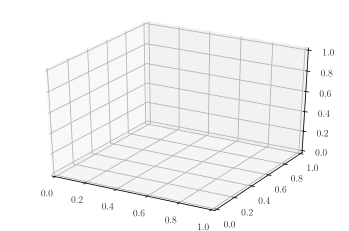

In [16]:
acc_rand = []
acc_vari = []
acc_sqsm = []
acc_RKHS = []
acc_Hvar = []
acc_l2fm = []

models = []

X_train_0   = X_train
y_train_0   = y_train
U_0         = U
y_U_0       = y_U

for score, acc in (zip((scores.calculate_scores_rand, scores.calculate_scores_vari, 
                        scores.calculate_scores_sqsm, scores.calculate_scores_RKHS, 
                        scores.calculate_scores_Hvar, scores.calculate_scores_l2fm),
                            (acc_rand, acc_vari, acc_sqsm, acc_RKHS, acc_Hvar, acc_l2fm))):
    X_train = X_train_0
    y_train = y_train_0
    U = U_0
    y_U = y_U_0
    
    k = GPy.kern.RBF(ndim, variance=var, lengthscale=lengthscale)
    m = GPy.core.GP(X=X_train,
                    Y=y_train.reshape(-1, 1), 
                    kernel=k, 
                    inference_method=GPy.inference.latent_function_inference.Laplace(),
                    likelihood=lik)
    
    for i in tqdm(range(start_num_of_dots, end_num_of_dots)):
        #0. learn GP on the data
        m = GPy.core.GP(X=X_train,
                        Y=y_train.reshape(-1, 1), 
                        kernel=k, 
                        inference_method=GPy.inference.latent_function_inference.Laplace(),
                        likelihood=lik)

        #1. calculate score at each point of the rest dataset in U and y_u, get the ind of maximum
        scores = score(np.array(U), m, X_train, y_train)
        ind = list(scores).index(max(scores))
        
        #2. append new point to the training dataset and remove it from U
        X_train = np.append(X_train, U[ind].reshape(-1, ndim), axis=0)
        y_train = np.append(y_train, y_U[ind].reshape(-1), axis=0)
        
        #placing this function call right here is important
        #since draw_score should see whole U included the point to be deleted
        draw_score(scores, U, "./score_plots_ndim/"+str(score)[27:31]+"/", i, m, X_train, y_train)
    
        U = np.delete(U, ind, axis = 0)
        y_U = np.delete(y_U, ind, axis = 0)

        #3. count accuracy and log_loss
        acc.append(accuracy_score(y_test, to_labels(m.predict(X_test)[0]))*X_test.shape[0])
        loss.append(log_loss(y_test, m.predict(X_test)[0]))
        
        #4. refresh parameters of the GP
        if i % start_num_of_dots == 0:
            m.optimize('bfgs', max_iters=100)
    
    #after the gp is learned save it to models
    models.append(m)
            


In [ ]:
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_rand[:len(acc_rand)], label='rand')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_vari[:len(acc_rand)], label='var')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_sqsm[:len(acc_rand)], label='L2')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_RKHS[:len(acc_rand)], label='RKHS')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_Hvar[:len(acc_rand)], label='Hvar')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_l2fm[:len(acc_rand)], label='l2fm')
plt.title("accuracy(num of dots)")
plt.xlabel("size of training dataset")
plt.ylabel("accuracy")
plt.legend()